In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx
import graph_tool.all as gt
from motif_counts import *
from tqdm.auto import tqdm
from collections import defaultdict
from collections import defaultdict
from tqdm import tqdm
from joblib import Parallel, delayed
import pickle
import matplotlib.pyplot as plt
import networkx as nx
#from tqdm.notebook import tqdm

In [2]:
keys_to_remove = [1, 2,3]

for k in keys_to_remove:
    motifs.pop(k, None) 

#
# 1) Grab the sorted list of remaining old keys
old_keys = sorted(motifs.keys())

# 2) Build a mapping old→new
old_to_new = { old: new for new, old in enumerate(old_keys, start=1) }

# 3) Re-index motifs, exp_counts, obs_counts
motifs      = { old_to_new[old]: motifs[old]      for old in old_keys }

In [3]:
dfg = pd.read_feather('mcns_fw_edge_comp.feather')
# 1) build a unique list of all node labels
labels = np.unique(np.concatenate([dfg['pre'].values, dfg['post'].values]))

# 2) create the graph and a string vertex‐property to store the label
g = gt.Graph(directed=True)
v_label = g.new_vp("string")
g.vp["label"] = v_label

# 3) add one vertex per label, keep a Python dict to map label→vertex
label2v = {}
for L in labels:
    v = g.add_vertex()
    label2v[L] = v
    v_label[v] = str(L)

# 4) create a float edge‐property for your weights
e_weight = g.new_ep("float")
g.ep["weight"] = e_weight

# 5) add all edges with their weights
edge_list = [
    (label2v[src], label2v[tgt], float(w))
    for src, tgt, w in dfg[['pre','post','weight_m']].itertuples(index=False)
]
g.add_edge_list(edge_list, eprops=[g.ep["weight"]])
loops = [e for e in g.edges() if e.source() == e.target()]
for e in loops:
    g.remove_edge(e)

In [4]:
#load specific or dimorphic
import json

with open('dim_types.json', 'r') as f:
   dim_types = json.load(f)

dim_types['dimorphic'], dim_types['specific']
#map index do dimorphism and specific
label2index = { lbl: int(vert) for lbl, vert in label2v.items() }
index2kind = {
    idx:
        'di' if label in dim_types['dimorphic']
        else 'sp' if label in dim_types['specific']
        else 'iso'
    for label, idx in label2index.items()
}

di_set = { idx for idx, kind in index2kind.items() if kind == 'di' }
sp_set = { idx for idx, kind in index2kind.items() if kind == 'sp' }
iso_set = { idx for idx, kind in index2kind.items() if ((kind != 'sp') & (kind != 'di')) }

In [ ]:
df = pd.read_feather('motifcounts_triplets.feather')
df['has_di'] = df[['node0','node1','node2']].isin(di_set).any(axis=1)
df['has_sp'] = df[['node0','node1','node2']].isin(sp_set).any(axis=1)
df['has_iso'] = df[['node0','node1','node2']].isin(iso_set).any(axis=1)
df_ds = df.loc[df['has_di'] | df['has_sp']]
df_iso = df.loc[~(df['has_di'] | df['has_sp']), :]

In [27]:
df_ds.shape[0]/df.shape[0]

0.15441519307658022

In [9]:
df_work = df_iso

In [10]:

# 1) canonical unchanged
def canonical(edges):
    best = None
    for perm in itertools.permutations([0,1,2]):
        mapped = tuple(sorted((perm[u], perm[v]) for u,v in edges))
        if best is None or mapped < best:
            best = mapped
    return best



# 3) enable a progress bar on pandas apply
tqdm.pandas(desc='Canonicalizing patterns')

# 4) compute canonicals with progress
df_work['canon'] = df_work['edges'].progress_apply(
    lambda arr: canonical([tuple(edge) for edge in arr])
)

df_work['pattern_id'] = pd.factorize(df_work['canon'])[0]

# 5) get counts per canonical pattern

me2paper_map = {0:3,1:5,2:2,3:1,4:6,5:12,6:11,7:8,8:4,9:10,10:13,11:9,12:7}
df_work['paper_id'] = df_work['pattern_id'].map(me2paper_map)
counts = df_work.groupby(['pattern_id','canon','paper_id']).size().rename('count').reset_index().sort_values('paper_id')
print(counts)


Canonicalizing patterns: 100%|██████████| 142518140/142518140 [10:48<00:00, 219689.29it/s]
/var/folders/hq/90ms91h54y12qm7xg8zcq34c0000gp/T/ipykernel_21805/2950665064.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['canon'] = df_work['edges'].progress_apply(
/var/folders/hq/90ms91h54y12qm7xg8zcq34c0000gp/T/ipykernel_21805/2950665064.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_work['pattern_id'] = pd.factorize(df_work['canon'])[0]
/var/folders/hq/90ms91h54y12qm7xg8zcq34c0000gp/T/ipyk

    pattern_id                                             canon  paper_id  \
3            3                                  ((0, 1), (0, 2))         1   
2            2                          ((0, 1), (1, 0), (2, 0))         2   
0            0                                  ((0, 1), (1, 2))         3   
8            8                          ((0, 1), (0, 2), (1, 2))         4   
1            1                                  ((0, 1), (2, 1))         5   
4            4                          ((0, 1), (0, 2), (1, 0))         6   
12          12                          ((0, 1), (1, 2), (2, 0))         7   
7            7                  ((0, 1), (0, 2), (1, 0), (1, 2))         8   
11          11                  ((0, 1), (0, 2), (1, 2), (2, 1))         9   
9            9                  ((0, 1), (0, 2), (1, 0), (2, 1))        10   
6            6                  ((0, 1), (0, 2), (1, 0), (2, 0))        11   
5            5          ((0, 1), (0, 2), (1, 0), (1, 2), (2, 0))

In [35]:
import sys
sys.getsizeof(df_iso)/1000000000

33.90370256

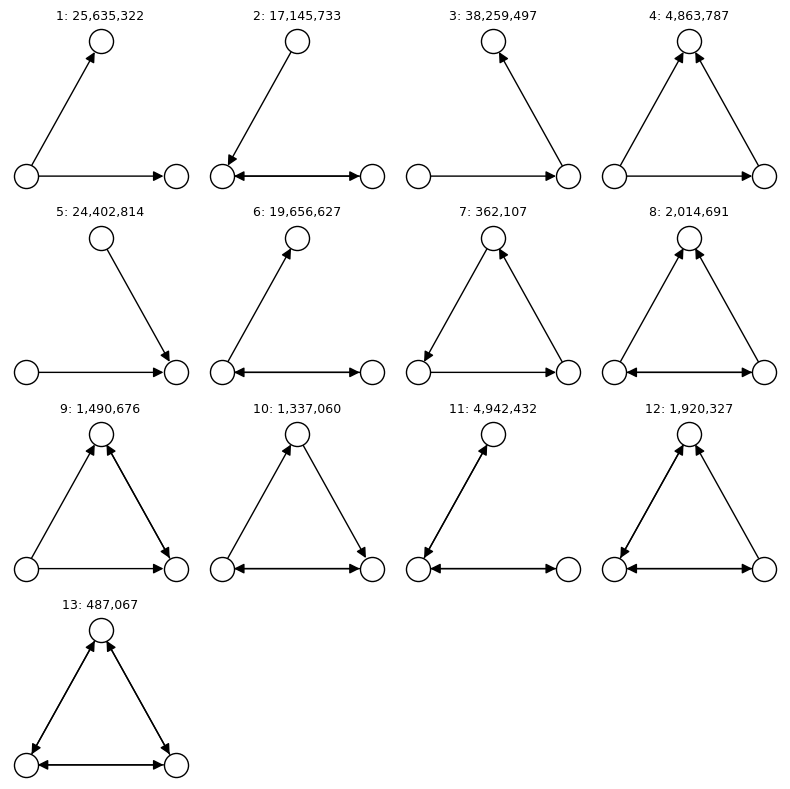

In [11]:
import matplotlib.pyplot as plt
import networkx as nx


counts_lookup = counts.set_index('pattern_id')[['paper_id','count']]

# fixed 3‐node layout
pos = {
    0: (0.0, 0.0),
    1: (1.0, 0.0),
    2: (0.5, 0.866)
}

def plot_triplet_with_counts(ax, key, counts):
    
    edge = counts.loc[counts['paper_id']==key,'canon'].item()
    oc = counts.loc[counts['paper_id']==key,'count'].item()
    G = nx.DiGraph()
    G.add_nodes_from([0,1,2])
    G.add_edges_from(edge)
    nx.draw_networkx_nodes(
    G, pos,ax=ax, 
    node_size=300,
    node_color='white',
    edgecolors='black'
    )
    
    for u, v in edge:
        if (v, u) in edge_list:
            rad   = 0.3 if u < v else -0.3
            style = f'arc3,rad={rad}'
        else:
            style = 'arc3,rad=0'

        nx.draw_networkx_edges(
            G, pos,
            edgelist=[(u, v)],
            ax=ax,
            arrowstyle='-|>',
            arrowsize=15,
            connectionstyle=style
        )



    ax.set_axis_off()
    ax.set_title(f"{key}: {oc:,}", fontsize=9)


# now make the 4×4 grid
cols = 4
rows = (len(motifs) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()
for ax, key in zip(axes, list(counts['paper_id'])):
    plot_triplet_with_counts(ax, key, counts)




for ax in axes[len(motifs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()


In [24]:
aaa

,ds,iso
0,4447903,25635332
1,4584694,24402814
2,7120929,38259497
3,763170,4863787
4,3602177,19656627
5,3315157,17145733
6,65332,362107
7,340581,2014691
8,258062,1490676
9,231829,1337060


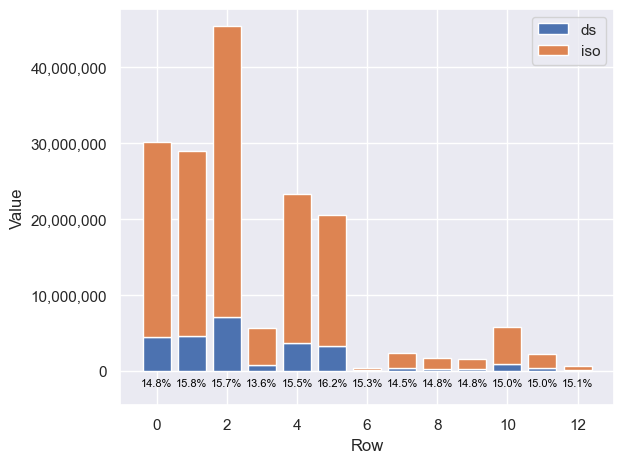

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

aaa = pd.read_csv('motif.ds.vs.iso.csv', usecols=['ds','iso'])

fig, ax = plt.subplots()
ax.bar(aaa.index, aaa['ds'],       label='ds')
ax.bar(aaa.index, aaa['iso'],      bottom=aaa['ds'], label='iso')

# compute a little bottom margin for the annotations
max_total = (aaa['ds'] + aaa['iso']).max()
margin    = max_total * 0.1
ax.set_ylim(-margin, None)

# add %-labels under each bar
for idx, (ds_val, iso_val) in enumerate(zip(aaa['ds'], aaa['iso'])):
    total = ds_val + iso_val
    pct   = (ds_val / total * 100) if total else 0
    ax.text(
        idx,            # x position
        -margin * 0.2,  # a bit below zero
        f'{pct:.1f}%',  # label
        ha='center',
        va='top',
        color='black',
        fontsize=8
    )

ax.set_xlabel('Row')
ax.set_ylabel('Value')
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: f'{int(x):,}'))

ax.legend()
plt.tight_layout()
plt.show()

aaa




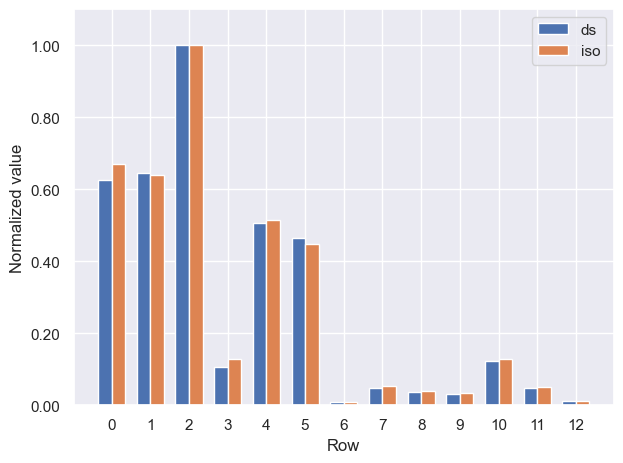

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# load and normalize
aaa       = pd.read_csv('motif.ds.vs.iso.csv', usecols=['ds','iso'])
ds_norm   = aaa['ds']  / aaa['ds'].max()
iso_norm  = aaa['iso'] / aaa['iso'].max()

fig, ax = plt.subplots()
width = 0.35
x     = aaa.index

# side by side bars
ax.bar(x - width/2, ds_norm,  width, label='ds')
ax.bar(x + width/2, iso_norm, width, label='iso')

# labels and legend
ax.set_xlabel('Row')
ax.set_ylabel('Normalized value')
ax.set_xticks(x)
ax.set_xticklabels(x)
ax.legend()

# format y axis with two decimals
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda v, p: f'{v:.2f}'))
ax.set_ylim(0, 1.1)

plt.tight_layout()
plt.show()


BASE MODEL

In [12]:
import networkx as nx

nxg = nx.DiGraph()

# 2) Add all nodes (we’ll keep the original integer IDs)
for v in g.vertices():
    vid = int(v)        # graph-tool uses Vertex objects, cast to int
    nxg.add_node(vid)
    
# 3) Add all directed edges
for e in g.edges():
    src = int(e.source())
    tgt = int(e.target())
    nxg.add_edge(src, tgt)

# 4) Now call your motif routines on the NX graph
triplet_pr, pair_pr = compute_three_neuron_motif_probabilities(nxg)
exp_counts     = compute_expected_three_neuron_motifs(nxg, triplet_pr)

1
1
0
2
0
1
0
1
2
1
1
2
0
1
1
2
1
0
1
1
0
2
0
0
1
2
1
0
1
2
1
1
2
2
0
1
2
0
1
0
1
2
2
0
1


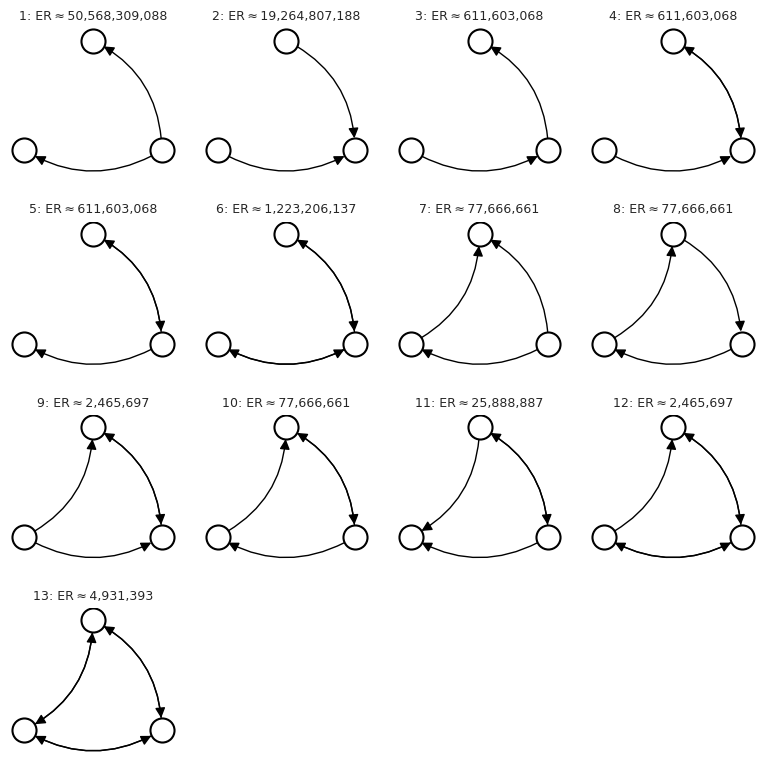

In [89]:
pos = {
    0: (0.0, 0.0),
    1: (1.0, 0.0),
    2: (0.5, 0.866)
}

def plot_triplet_with_exp(triplet, motif_id, exp_counts, ax):
    # build a tiny DiGraph
    G = nx.DiGraph()
    G.add_nodes_from([0,1,2])
    edges = triplet.get_edges()
    G.add_edges_from(edges)
    
    # draw nodes
    nx.draw_networkx_nodes(
        G, pos, ax=ax,
        node_size=300,
        node_color='white',
        edgecolors='black'
    )
    
    # draw edges (curved if reciprocal)
    for u, v in edges:
        if (v, u) in edges:
            rad = 0.3 if u < v else -0.3
            nx.draw_networkx_edges(
                G, pos, edgelist=[(u,v)], ax=ax,
                arrowstyle='-|>',
                arrowsize=15,
                connectionstyle=f'arc3,rad={rad}'
            )

    ax.set_axis_off()
    # title with motif ID and formatted expected count
    ec = exp_counts.get(motif_id, float('nan'))
    ax.set_title(f"{motif_id}: ER ≈ {ec:,.0f}", fontsize=9)

# layout grid
cols = 4
rows = (len(motifs) + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()

# plot each motif
for ax, (mid, tri) in zip(axes, motifs.items()):
    plot_triplet_with_exp(tri, mid, exp_counts, ax)

# hide any extra axes
for ax in axes[len(motifs):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()
